# 2D Eye-Tracking Camera Animation

This notebook demonstrates animated 2D camera views showing how the eye-tracking cameras observe eye movements including:
1. **Saccades**: Fast eye movements (e.g., left to right jumps)
2. **Smooth pursuit**: Slow tracking movements
3. **Complex patterns**: Combinations of horizontal and vertical movements

Gaze directions range from -20° to +20° horizontally and -15° to +15° vertically.

## Imports and Setup

In [1]:
%matplotlib widget

import seet.device as device
import seet.scene as scene
import seet.user as user
import seet.visualization.scene_visualization as scene_visualization
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import torch
import os
import sys
sys.path.append("..")
import utils

dropdown_widget = utils.get_experiment_info(save_results=False)

RadioButtons(description='Device:', options=('default',), value='default')

## Create Scene Model

In [2]:
# Create a scene
scene_file_name, _ = \
    utils.get_configuration_files(dropdown_widget.value)  # type: ignore

et_scene = scene.SceneModel(parameter_file_name=scene_file_name)

print(f"Scene loaded from: {scene_file_name}")
print(f"Number of eyes: {len(et_scene.user.eyes)}")
print(f"Number of subsystems: {len(et_scene.device.subsystems)}")

Scene loaded from: C:\Users\padossa\repos\seet-1\seet\scene\default_scene/default_scene.json
Number of eyes: 2
Number of subsystems: 2


## 2D Eye Movement Animation

Animate the 2D camera views showing realistic eye movement patterns:
- **Phase 1 (0-3s)**: Horizontal saccades (fast left-right movements)
- **Phase 2 (3-6s)**: Vertical smooth pursuit (slow up-down tracking)
- **Phase 3 (6-9s)**: Diagonal movements (combined horizontal/vertical)
- **Phase 4 (9-12s)**: Complex pattern (figure-8 like movement)
- **Phase 5 (12-15s)**: Return to center with final saccades

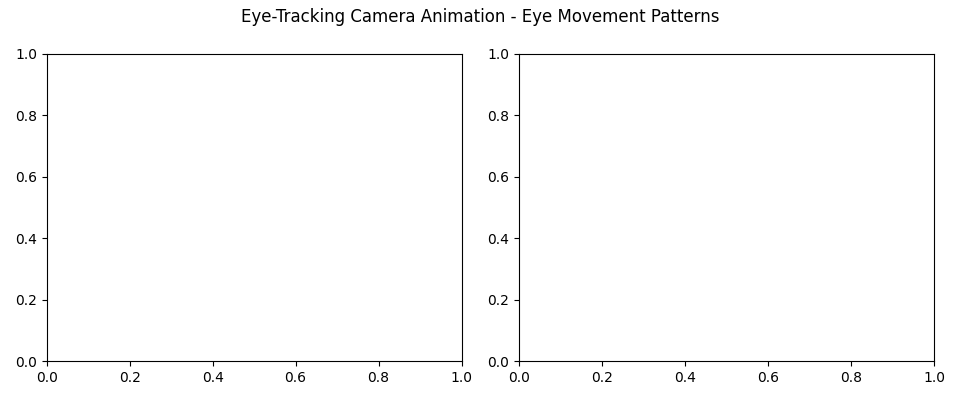

2D Eye Movement Animation includes:
1. Horizontal saccades: Fast left-right movements (0-3s)
2. Vertical smooth pursuit: Slow up-down tracking (3-6s)
3. Diagonal movements: Square pattern (6-9s)
4. Figure-8 pattern: Complex smooth movements (9-12s)
5. Return to center: Final saccades and settling (12-15s)

Movement ranges: ±20.0° horizontal, ±15.0° vertical
Total duration: 15 seconds at 30 fps (450 frames)

DEBUG: torch default dtype = torch.float32

Saving animation to eye_tracking_2D_movement_animation.mp4 using FFmpeg...


In [ ]:
# Setup for 2D camera views
# Ensure consistent float32 dtype for compatibility with matplotlib
torch.set_default_dtype(torch.float32)

subsystem_index = 0
camera_index = 0

subsystem = et_scene.device.subsystems[subsystem_index]
camera = subsystem.cameras[camera_index]
resolution = camera.resolution.clone().detach().numpy()

# Calculate figure size based on camera resolution
figsize = np.array([2, 1]) * resolution
height_in = 8
figsize = [height_in, height_in * figsize[1] / figsize[0]]

# Animation parameters
fps = 30
duration_seconds = 15  # Extended duration for complex eye movement patterns
num_frames = fps * duration_seconds  # 450 frames for 15 seconds at 30 fps
interval_ms = 1000 / fps  # ~33.33ms for 30 fps

# Eye movement ranges (in degrees)
max_horizontal = 20.0  # -20° to +20°
max_vertical = 15.0    # -15° to +15°

# Define complex eye movement pattern with 5 phases
phase_frames = num_frames // 5  # 90 frames per phase (3 seconds each)

def get_gaze_angles(frame):
    """Calculate gaze angles for realistic eye movement patterns"""
    phase = frame // phase_frames
    local_frame = frame % phase_frames
    progress = local_frame / (phase_frames - 1) if phase_frames > 1 else 0
    progress = max(0, min(1, progress))  # Clamp to [0, 1]
    
    if phase == 0:
        # Phase 1: Horizontal saccades (fast left-right movements)
        # Create step-like saccadic movements with 5 positions
        saccade_positions = [-20, -10, 0, 10, 20]  # 5 positions
        position_frames = phase_frames // len(saccade_positions)
        position_index = min(local_frame // position_frames, len(saccade_positions) - 1)
        horizontal = saccade_positions[position_index]
        vertical = 0.0
        description = f"Saccades (H={horizontal:.0f}°)"
        
    elif phase == 1:
        # Phase 2: Vertical smooth pursuit (slow up-down tracking)
        vertical = max_vertical * np.sin(2 * np.pi * progress)  # Smooth sinusoidal
        horizontal = 0.0
        description = f"Smooth Pursuit (V={vertical:.1f}°)"
        
    elif phase == 2:
        # Phase 3: Diagonal movements (combined horizontal/vertical)
        # Move in a square pattern
        if progress < 0.25:
            # Top-right
            t = progress / 0.25
            horizontal = max_horizontal * t
            vertical = max_vertical * t
        elif progress < 0.5:
            # Top-left
            t = (progress - 0.25) / 0.25
            horizontal = max_horizontal * (1 - 2*t)
            vertical = max_vertical
        elif progress < 0.75:
            # Bottom-left
            t = (progress - 0.5) / 0.25
            horizontal = -max_horizontal
            vertical = max_vertical * (1 - 2*t)
        else:
            # Back to center
            t = (progress - 0.75) / 0.25
            horizontal = -max_horizontal * (1 - t)
            vertical = -max_vertical * (1 - t)
        description = f"Diagonal (H={horizontal:.1f}°, V={vertical:.1f}°)"
        
    elif phase == 3:
        # Phase 4: Complex pattern (figure-8 like movement)
        t = 2 * np.pi * progress
        horizontal = max_horizontal * 0.8 * np.sin(t)
        vertical = max_vertical * 0.6 * np.sin(2 * t)  # Double frequency for figure-8
        description = f"Figure-8 (H={horizontal:.1f}°, V={vertical:.1f}°)"
        
    else:  # phase == 4
        # Phase 5: Return to center with final saccades
        if progress < 0.3:
            # Quick saccade to extreme position
            horizontal = max_horizontal * np.sign(np.sin(4 * np.pi * progress))
            vertical = max_vertical * 0.5 * np.sign(np.cos(6 * np.pi * progress))
        elif progress < 0.7:
            # Slow return to center
            decay = 1 - (progress - 0.3) / 0.4
            horizontal = max_horizontal * 0.3 * decay * np.sin(8 * np.pi * progress)
            vertical = max_vertical * 0.2 * decay * np.cos(6 * np.pi * progress)
        else:
            # Final settling to center
            decay = 1 - (progress - 0.7) / 0.3
            horizontal = 2.0 * decay * np.sin(20 * np.pi * progress)
            vertical = 1.0 * decay * np.cos(15 * np.pi * progress)
        description = f"Return to Center (H={horizontal:.1f}°, V={vertical:.1f}°)"
    
    return horizontal, vertical, description

# Create figure for animation
fig_anim, axs_anim = plt.subplots(nrows=1, ncols=2, figsize=(figsize[0] * 1.2, figsize[1]))
plt.suptitle("Eye-Tracking Camera Animation - Eye Movement Patterns")

# Titles for left and right eye
eye_titles = ["Left Eye", "Right Eye"]

def animate_2d(frame):
    """Animation function for 2D eye movement"""
    # Get gaze angles for this frame
    horizontal, vertical, description = get_gaze_angles(frame)
    angles_deg = torch.tensor([horizontal, vertical], dtype=torch.float32)
    
    # Clear both axes
    for ax in axs_anim:
        ax.clear()
    
    # Apply rotation to both eyes
    for eye in et_scene.user.eyes:
        eye.rotate_from_gaze_angles_inParent(angles_deg)
    
    # Visualize each eye
    for i in range(2):
        ax = axs_anim[1 - i]  # Flip for intuitive left/right display
        ax.set_title(eye_titles[i])
        ax.grid(True, alpha=0.3)
        
        # Create image visualization for this subsystem
        et_image_visualization = \
            scene_visualization.ImageVisualization(
                et_scene, ax, subsystem_index=i
            )
        
        # Visualize different eye features
        et_image_visualization.visualize_refracted_pupil()
        et_image_visualization.visualize_cornea()
        et_image_visualization.visualize_glints()
        et_image_visualization.visualize_limbus()
        et_image_visualization.visualize_eyelids()
    
    # Reset eye rotation for next frame
    for eye in et_scene.user.eyes:
        eye.unrotate_from_gaze_angles_inParent(angles_deg)
    
    # Update main title with current movement info
    phase_num = (frame // phase_frames) + 1
    overall_progress = (frame + 1) / num_frames * 100
    plt.suptitle(f"Eye-Tracking Camera Animation\n"
                f"{description} | Phase {phase_num}/5 | Progress: {overall_progress:.1f}%")
    
    return []

# Create animation
anim_2d = animation.FuncAnimation(
    fig_anim, animate_2d, frames=num_frames,
    interval=interval_ms, blit=False, repeat=True
)

plt.tight_layout()
plt.show()

print(f"2D Eye Movement Animation includes:")
print(f"1. Horizontal saccades: Fast left-right movements (0-3s)")
print(f"2. Vertical smooth pursuit: Slow up-down tracking (3-6s)")
print(f"3. Diagonal movements: Square pattern (6-9s)")
print(f"4. Figure-8 pattern: Complex smooth movements (9-12s)")
print(f"5. Return to center: Final saccades and settling (12-15s)")
print(f"")
print(f"Movement ranges: ±{max_horizontal}° horizontal, ±{max_vertical}° vertical")
print(f"Total duration: {duration_seconds} seconds at {fps} fps ({num_frames} frames)")

# Debug tensor dtypes
print(f"\nDEBUG: torch default dtype = {torch.get_default_dtype()}")

# Save animation as MP4
try:
    mp4_filename = "eye_tracking_2D_movement_animation.mp4"
    print(f"\nSaving animation to {mp4_filename} using FFmpeg...")
    writer = animation.FFMpegWriter(fps=fps, bitrate=2500)
    anim_2d.save(mp4_filename, writer=writer)
    print(f"Animation saved successfully as {mp4_filename}")
except Exception as e:
    print(f"Could not save animation as MP4: {e}")
    print(f"Error type: {type(e).__name__}")
    print("Check if FFmpeg is installed: conda install ffmpeg")

print("\nNote: Animation demonstrates realistic eye movement patterns including")
print("saccades (fast jumps) and smooth pursuit (tracking movements).")

## Animation Description

This animation demonstrates realistic eye movement patterns that would be observed in actual eye-tracking scenarios:

### **Movement Types:**

1. **Saccades (0-3 seconds)**:
   - Fast, ballistic eye movements
   - Discrete jumps between fixation points
   - Horizontal positions: -20°, -10°, 0°, +10°, +20°
   - Typical duration: ~200-500ms per saccade

2. **Smooth Pursuit (3-6 seconds)**:
   - Slow, continuous tracking movements
   - Vertical sinusoidal pattern (±15°)
   - Used to track moving objects
   - Velocity: ~30°/second maximum

3. **Diagonal Movements (6-9 seconds)**:
   - Combined horizontal and vertical components
   - Square pattern visiting corners
   - Demonstrates coordinated eye movements

4. **Complex Pattern (9-12 seconds)**:
   - Figure-8 trajectory
   - Smooth, coordinated movements
   - Tests system precision for complex paths

5. **Return to Center (12-15 seconds)**:
   - Final saccades and microsaccades
   - Gradual settling to central fixation
   - Demonstrates system stability

### **Observable Features:**

- **Pupil movement**: Changes in pupil position relative to camera frame
- **Corneal reflections**: Glint positions shift with gaze direction
- **Limbus visibility**: Iris boundary appearance changes with eye rotation
- **Eyelid interactions**: Natural eyelid movement with vertical gaze changes
- **Feature tracking**: How different eye features move in camera coordinates

This animation is valuable for:
- **Algorithm development**: Testing eye-tracking algorithms across movement types
- **System validation**: Verifying tracking accuracy for different gaze patterns
- **Educational purposes**: Understanding how eye movements appear in camera data
- **Performance analysis**: Evaluating system response to various movement velocities